In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using SharedArrays
using Statistics
using Plots
using DelimitedFiles
using DataFrames
using ProgressMeter

# Import data

In [2]:
#schneider data
train, test, toy = schneider_data();
all_schneider = [train; test]

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
jonklaas_tspan = (0.0, 8.0)

(0.0, 8.0)

# Helper functions needed for simulations

In [3]:
# gives 400 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end
# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end
# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
function blakesley_t4_neg_logl(sol, time, data, Vp, σ)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_t3_neg_logl(sol, time, data, Vp, σ)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T3_predicted = sol(time[i])[2] * 651.0 / Vp
            tot_loss += (T3_predicted - data[i, 2])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_tsh_neg_logl(sol, time, data, Vtsh, σ)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[3] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 3])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function jonklaas_t3_neg_logl(sol, time, data, Vp, σ)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T3_predicted = sol(time[i]) * 651.0 / Vp
            tot_loss += (T3_predicted - data[i])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end

jonklaas_t3_neg_logl (generic function with 1 method)

# Result

In [4]:
# all mauricio's sugested parameters on 100 patients
fitting_index = 
    [1; 11; 
    13; 14; 15; 16; 17; 18; 19; # T4 -> T3 conversion
    30; 31; 32; 34; 35;     
    36; 37; 40; 41; 42; 44;  
    49; 50; 51; 52; 53; 54;  # hill function parameters
    61; 62; 63; 64]          # variance parameters
initial_guess = [
    0.00174155; 0.88; 
    0.00998996; 2.85; 6.63*10^-4; 95; 0.00074619; 0.075; 3.3572*10^-4;
    101; 47.64; 0.0; 0.53; 0.226; 
    23; 0.118; 0.037; 0.0034; 5; 0.12;
    4.57; 3.90; 11.0; 5.0; 3.5; 8.0;
    1.0; 1.0; 1.0; 1.0]
train_minimizer = [0.0023270355487888627, 0.7171685278808142, 0.015068194504025835, 
    2.8187126590335296, 0.014017863406291608, 66.2203366473216, 0.00029602421763949365, 
    0.21720377134607735, 0.00037260050728968975, 34.142639266367816, 49.157091382501996, 
    0.04179772946801207, 0.0862392128692788, 0.15662006742955717, 1.4573477225422837, 
    0.21771677444046755, 0.04637489478468422, 0.03717943631716221, 7.287925716726416, 
    0.15294385480638942, 3.8316984821258115, 4.063409551071582, 0.601205062162589, 
    5.852844670297537, 2.704847627097717, 9.78513372088566, 3.4528550320908384, 
    0.13202290209699818, 0.2345117581046315, 0.5327408169292783];

## Blakesley data (T4 and TSH data)

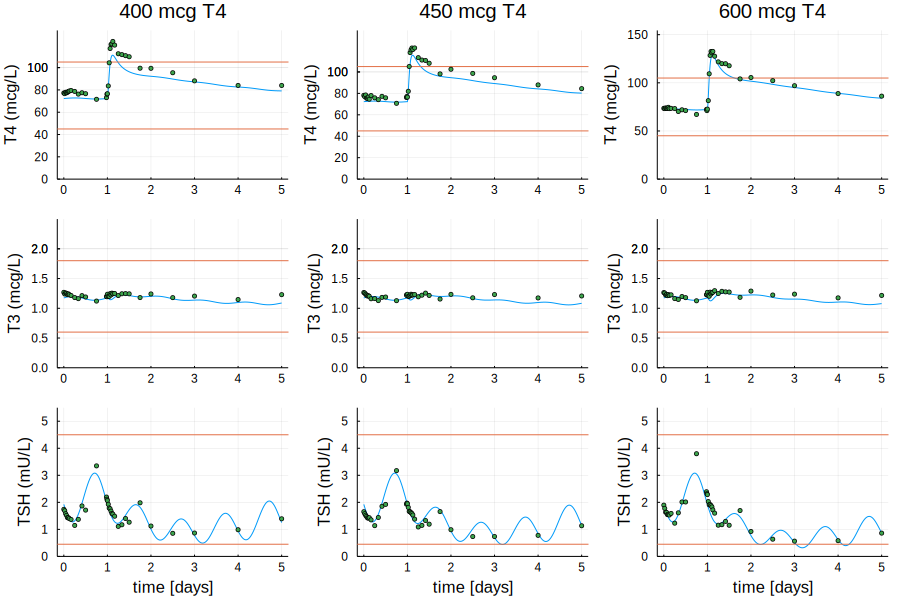

In [5]:
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
p[fitting_index] = train_minimizer

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400", title="400 mcg T4")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450", title="450 mcg T4")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600", title="600 mcg T4")

blakesley_plot = plot(a, b, c, layout=(1, 3), size=(900, 600))

In [9]:
savefig(blakesley_plot, "blakesley_plot.svg")

## Jonklaas data (T3 data)
overweight patients are those with BMI > 30.

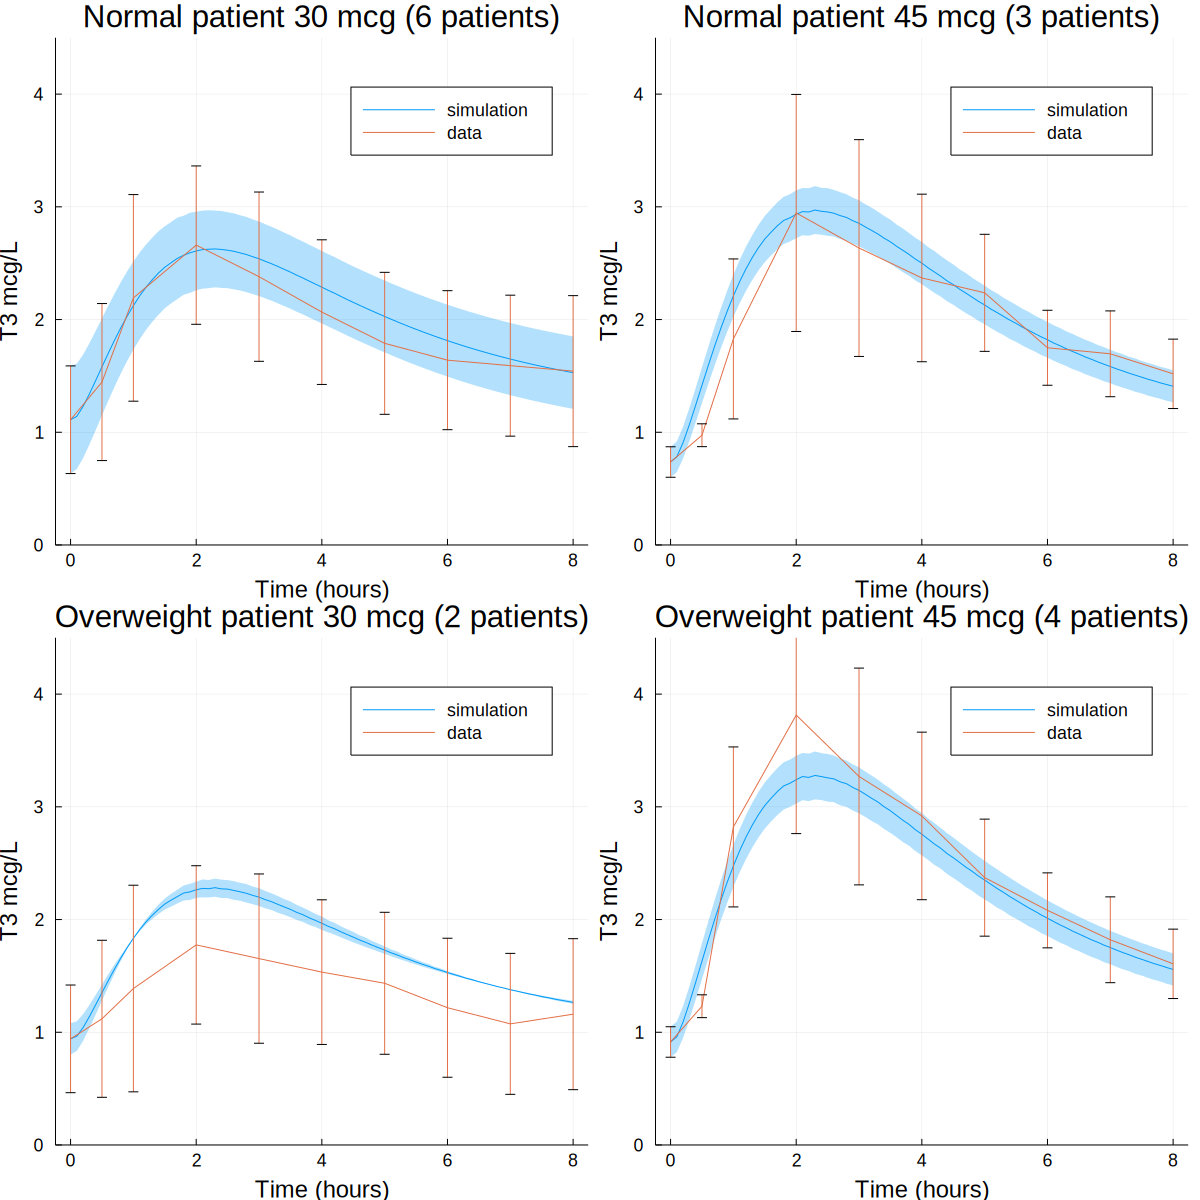

In [6]:
function jonklass_plot()
    jonklaas_times_simulation = collect(0.0:0.1:8.0)
    jonklaas_times_realdata = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0] # same time invervals as data
    points = length(jonklaas_times_simulation)
    normal_45_T4  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_T3  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_TSH = [Float64[] for i in 1:points]     # 3 patients
    normal_30_T4  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_T3  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_TSH = [Float64[] for i in 1:points]     # 6 patients
    overweight_45_T4  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_T3  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_TSH = [Float64[] for i in 1:points] # 4 patients
    overweight_30_T4  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_T3  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_TSH = [Float64[] for i in 1:points] # 2 patients

    for i in 1:15
        height, weight, sex = patient_param[i, :]
        T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
        T3dose = patient_dose[i]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        p[55] = 0.0
        p[56] = T3dose / 651.0
        cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
        p[fitting_index] = train_minimizer
        prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
        sol = solve(prob)

        BMI = weight / height^2
        if BMI < 30
            # normal patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        else
            # overweight patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        end
    end

    # compute averages
    normal_45_T4_mean = mean.(normal_45_T4)      # 3 patients
    normal_45_T3_mean = mean.(normal_45_T3)      # 3 patients
    normal_45_TSH_mean = mean.(normal_45_TSH)     # 3 patients
    normal_30_T4_mean = mean.(normal_30_T4)      # 6 patients
    normal_30_T3_mean = mean.(normal_30_T3)      # 6 patients
    normal_30_TSH_mean = mean.(normal_30_TSH)     # 6 patients
    overweight_45_T4_mean = mean.(overweight_45_T4)  # 4 patients
    overweight_45_T3_mean = mean.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_mean = mean.(overweight_45_TSH) # 4 patients
    overweight_30_T4_mean = mean.(overweight_30_T4)  # 2 patients
    overweight_30_T3_mean = mean.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_mean = mean.(overweight_30_TSH) # 2 patients

    # compute sample standard deviations
    normal_45_T4_std = std.(normal_45_T4)      # 3 patients
    normal_45_T3_std = std.(normal_45_T3)      # 3 patients
    normal_45_TSH_std = std.(normal_45_TSH)     # 3 patients
    normal_30_T4_std = std.(normal_30_T4)      # 6 patients
    normal_30_T3_std = std.(normal_30_T3)      # 6 patients
    normal_30_TSH_std = std.(normal_30_TSH)     # 6 patients
    overweight_45_T4_std = std.(overweight_45_T4)  # 4 patients
    overweight_45_T3_std = std.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_std = std.(overweight_45_TSH) # 4 patients
    overweight_30_T4_std = std.(overweight_30_T4)  # 2 patients
    overweight_30_T3_std = std.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_std = std.(overweight_30_TSH); # 2 patients

    # now add data
    normal_45_T4_data  = zeros(10, 3)     # 3 patients
    normal_45_T3_data  = zeros(10, 3)     # 3 patients
    normal_45_TSH_data = zeros(10, 3)     # 3 patients
    normal_30_T4_data  = zeros(10, 6)     # 6 patients
    normal_30_T3_data  = zeros(10, 6)     # 6 patients
    normal_30_TSH_data = zeros(10, 6)     # 6 patients
    overweight_45_T4_data  = zeros(10, 4) # 4 patients
    overweight_45_T3_data  = zeros(10, 4) # 4 patients
    overweight_45_TSH_data = zeros(10, 4) # 4 patients
    overweight_30_T4_data  = zeros(10, 2) # 2 patients
    overweight_30_T3_data  = zeros(10, 2) # 2 patients
    overweight_30_TSH_data = zeros(10, 2) # 2 patients

    normal_45_counter = 1
    normal_30_counter = 1
    overweight_45_counter = 1
    overweight_30_counter = 1
    for i in 1:15
        height, weight, sex = patient_param[i, :]
        BMI = weight / height^2
        T3dose = patient_dose[i]

        if BMI < 30
            # normal patient
            if T3dose == 30
                normal_30_T4_data[:, normal_30_counter] .= patient_t4[i, :]
                normal_30_T3_data[:, normal_30_counter] .= patient_t3[i, :]
                normal_30_TSH_data[:, normal_30_counter] .= patient_tsh[i, :]
                normal_30_counter += 1
            else
                normal_45_T4_data[:, normal_45_counter] .= patient_t4[i, :]
                normal_45_T3_data[:, normal_45_counter] .= patient_t3[i, :]
                normal_45_TSH_data[:, normal_45_counter] .= patient_tsh[i, :]
                normal_45_counter += 1
            end
        else
            # overweight patient
            if T3dose == 30
                overweight_30_T4_data[:, overweight_30_counter] .= patient_t4[i, :]
                overweight_30_T3_data[:, overweight_30_counter] .= patient_t3[i, :]
                overweight_30_TSH_data[:, overweight_30_counter] .= patient_tsh[i, :]
                overweight_30_counter += 1
            else
                overweight_45_T4_data[:, overweight_45_counter] .= patient_t4[i, :]
                overweight_45_T3_data[:, overweight_45_counter] .= patient_t3[i, :]
                overweight_45_TSH_data[:, overweight_45_counter] .= patient_tsh[i, :]
                overweight_45_counter += 1
            end
        end
    end

    # mean and std of data
    normal_45_T3_data_mean = mean(normal_45_T3_data, dims=2)
    normal_30_T3_data_mean = mean(normal_30_T3_data, dims=2)
    overweight_45_T3_data_mean = mean(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_mean = mean(overweight_30_T3_data, dims=2)
    normal_45_T3_data_std = std(normal_45_T3_data, dims=2)
    normal_30_T3_data_std = std(normal_30_T3_data, dims=2)
    overweight_45_T3_data_std = std(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_std = std(overweight_30_T3_data, dims=2);

    Plots.scalefontsizes(1.5)

    # normal patients 45 mcg T4 plot
    normal_45_graph = plot(jonklaas_times_simulation, normal_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Normal patient 45 mcg (3 patients)")
    normal_45_graph = plot!(normal_45_graph, jonklaas_times_realdata, normal_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # normal patients 30 mcg T4 plot
    normal_30_graph = plot(jonklaas_times_simulation, normal_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_30_T3_std, fillalpha=.3, title="Normal patient 30 mcg (6 patients)")
    normal_30_graph = plot!(normal_30_graph, jonklaas_times_realdata, normal_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std)

    # overweight patients 45 mcg T4 plot
    overweight_45_graph = plot(jonklaas_times_simulation, overweight_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Overweight patient 45 mcg (4 patients)")
    overweight_45_graph = plot!(overweight_45_graph, jonklaas_times_realdata, overweight_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # overweight patients 30 mcg T4 plot
    overweight_30_graph = plot(jonklaas_times_simulation, overweight_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=overweight_30_T3_std, fillalpha=.3, title="Overweight patient 30 mcg (2 patients)")
    overweight_30_graph = plot!(overweight_30_graph, jonklaas_times_realdata, overweight_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std);
    
    combine = plot(normal_30_graph, normal_45_graph, 
        overweight_30_graph, overweight_45_graph, 
        layout=(2, 2), size=(1200, 1200))
    return combine
end
combine = jonklass_plot()

In [8]:
savefig(combine, "jonklaas_fig.svg")

# Schneider plots

For each patient, we test various T4 doses (in intervals of 12.5 mcg) to see if they normalize TSH values, then compare it to data.

## Possible doses

We will test T4 doses from 62.5, 75 ... all the way to 325 mcg. The smallest and largest doses that achieve euthyroidism (i.e. $0.5 <=$ TSH in last day $<= 4.5$) will be used as the **predicted dosage**. 

+ min/max weight = 38.1/206.4 KG 
+ using 1.6 of T4 per KG -> 61 ~ 330 mcg of T4
+ So test dosages = 50 ~ 337.5 with 12.5 as increments

In [7]:
# helper functions
function find_doses(
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    tspan::Float64,
    cbk, # call back function
    p,   # parameter vector
    ic;  # initial condition
    tsh_only::Bool = true
    )
    
    possible_doses = collect(50.0:12.5:325.0)
    mindose = 0.0
    maxdose = 0.0
    
    # check doses from bottom up
    for dose in possible_doses
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 7])
        if tsh_only
            loss  = TSH_within_interval(sol, p[48])
        else
            loss  = TSH_and_T4_within_interval(sol, p[48], p[47])
        end
        
        # save doses that work
        if loss == 1
            mindose = dose
            break
        end
    end
    if mindose == 0
        mindose = Inf
    end
    
    # check doses from top to bottom
    reverse!(possible_doses)
    for dose in possible_doses
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 7])
        if tsh_only
            loss  = TSH_within_interval(sol, p[48])
        else
            loss  = TSH_and_T4_within_interval(sol, p[48], p[47])
        end
        
        # save doses that work
        if loss == 1
            maxdose = dose
            break
        end
    end
    if maxdose == 0 
        maxdose = Inf
    end
    
    return maxdose, mindose
end

function TSH_within_interval(sol, Vtsh)
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if 0.5 ≤ tsh ≤ 4.5
        return true
    end
    return false
end

function TSH_and_T4_within_interval(sol, Vtsh, Vp)
    tot_loss = 0
    t4  = sol.u[end][1] * 777.0 / Vp
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if (0.5 ≤ tsh ≤ 4.5) && (45 ≤ t4 ≤ 120)
        return true
    end
    return false
end

TSH_and_T4_within_interval (generic function with 1 method)

In [8]:
function find_all_doses(train_data, train_minimizer, fitting_index; tsh_only::Bool=true)
    # parse data
    height = train_data[!, Symbol("Ht.m")]
    weight = train_data[!, Symbol("Wt.kg")]
    sex    = train_data[!, Symbol("Sex")]
    tspan  = 24train_data[!, Symbol("Days.to.euthyroid")]
    init_tsh = train_data[!, Symbol("TSH.preop")]
    
    # define vector of possible doses
    min_predicted_doses = zeros(size(train_data, 1))
    max_predicted_doses = zeros(size(train_data, 1))
    
    # model setup
    dial  = [0.0; 0.88; 0.0; 0.88]
    scale_Vp = true
    
    # loop over each patient
    pmeter = Progress(size(train_data, 1))
    Threads.@threads for i in 1:size(train_data, 1)
        cbk   = PeriodicCallback(add_dose!, 24.0)# function to add dose
        w     = weight[i]
        h     = height[i]
        s     = Bool(sex[i])
        t     = Float64(tspan[i])
        ic, p = initialize(dial, scale_Vp, h, w, s)
        p[fitting_index] = train_minimizer
        ic[7] = init_tsh[i]

        # find dose
        (maxdose, mindose) = find_doses(h, w, s, t, cbk, p, ic, tsh_only=tsh_only)
        min_predicted_doses[i] = mindose
        max_predicted_doses[i] = maxdose
        next!(pmeter)
    end
    
    return max_predicted_doses, min_predicted_doses
end

find_all_doses (generic function with 1 method)

In [9]:
Threads.nthreads()

8

## Check max/avg/min predicted dose based on TSH or TSH+T4

In [10]:
# check Tsh and T4 (15 patients)
@time max_predicted_doses, min_predicted_doses = find_all_doses(all_schneider, 
    train_minimizer, fitting_index, tsh_only=true)
avg_predicted_doses = (min_predicted_doses + max_predicted_doses) ./ 2
result = [max_predicted_doses avg_predicted_doses min_predicted_doses]

Progress: 100%|█████████████████████████████████████████| Time: 0:24:51


1491.244538 seconds (4.80 G allocations: 240.660 GiB, 4.46% gc time)


554×3 Array{Float64,2}:
 150.0  131.25  112.5
 162.5  143.75  125.0
 162.5  143.75  125.0
 175.0  150.0   125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  137.5   112.5
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
   ⋮                 
 162.5  143.75  125.0
 150.0  131.25  112.5
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
 162.5  143.75  125.0
 150.0  131.25  112.5
 162.5  143.75  125.0
 162.5  143.75  125.0

In [11]:
writedlm("schneider_dosage_prediction_result.txt", result)

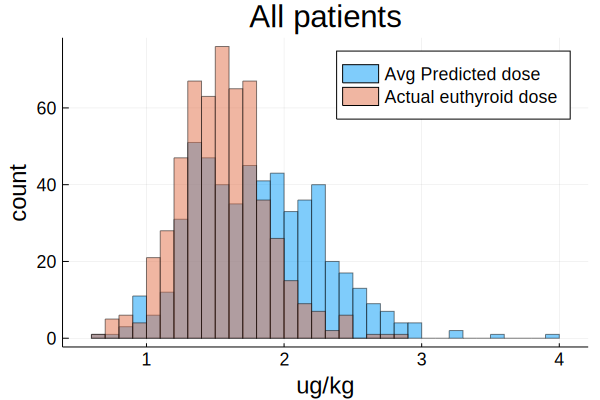

In [31]:
# import predicted dosages: max-dose/avg-dose/min-dose
dosage_predicted = readdlm("schneider_dosage_prediction_result.txt")

# predicted dose
predicted_t4 = dosage_predicted[:, 2] ./ all_schneider[!, Symbol("Wt.kg")]
avgplt_all = histogram(predicted_t4, title="All patients", bin=50, 
    xlabel="ug/kg", ylabel="count", label="Avg Predicted dose", alpha=0.5)

# actual dose
actual_t4 = all_schneider[!, Symbol("LT4.euthyroid.dose")] ./ all_schneider[!, Symbol("Wt.kg")]
histogram!(avgplt_all, actual_t4, label="Actual euthyroid dose", bin=30, alpha=0.5)

In [13]:
male_idx = findall(iszero, all_schneider[!, :Sex])
female_idx = findall(isone, all_schneider[!, :Sex]);

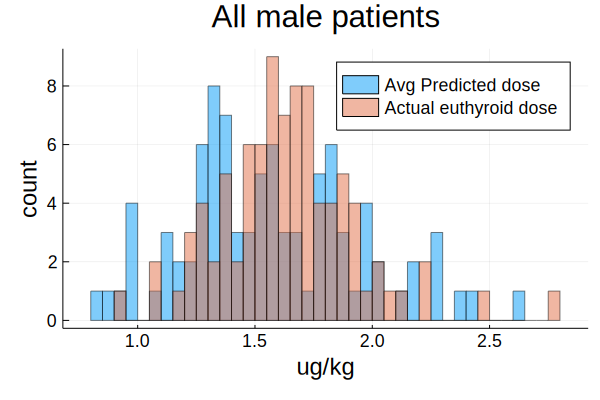

In [30]:
# make male plot
dosage_predicted = readdlm("schneider_dosage_prediction_result.txt")
predicted_t4 = dosage_predicted[male_idx, 2] ./ all_schneider[male_idx, Symbol("Wt.kg")]
avgplt_male = histogram(predicted_t4, title="All male patients", bin=50, 
    xlabel="ug/kg", ylabel="count", label="Avg Predicted dose", alpha=0.5)

# actual dose
actual_t4 = all_schneider[male_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[male_idx, Symbol("Wt.kg")]
histogram!(avgplt_male, actual_t4, label="Actual euthyroid dose", bin=50, alpha=0.5)

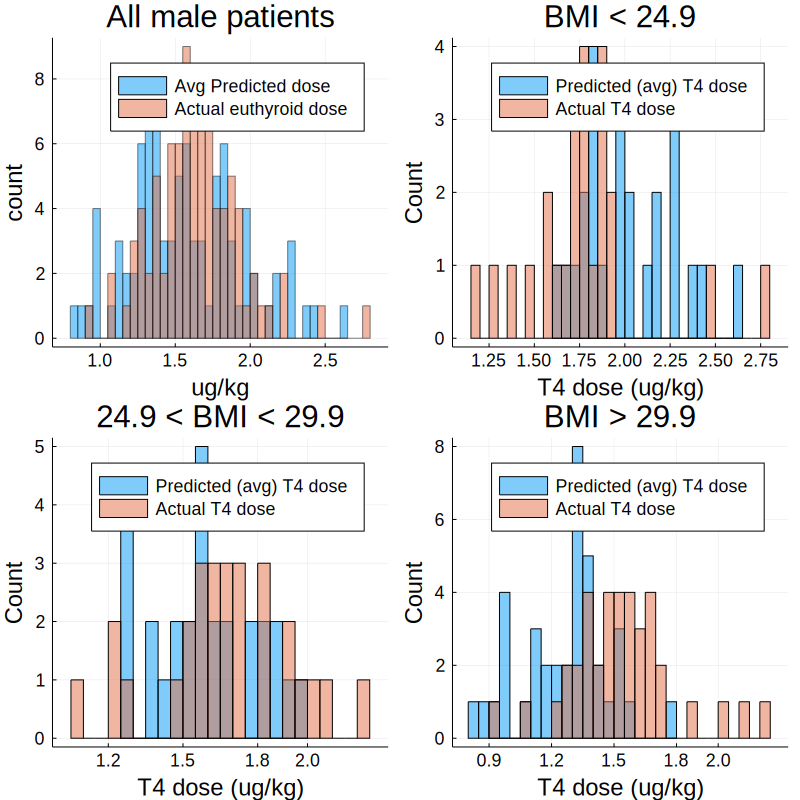

In [33]:

# import predicted dosages: max-dose/avg-dose/min-dose
dosage_predicted = readdlm("schneider_dosage_prediction_result.txt")
normal_idx = findall(bmi -> bmi < 24.9, all_schneider[!, :BMI])
overwt_idx = findall(bmi -> 24.9 <= bmi < 29.9, all_schneider[!, :BMI])
obese_idx  = findall(bmi -> 29.9 <= bmi, all_schneider[!, :BMI]);
normal_male_idx = findall(iszero, all_schneider[normal_idx, :Sex])
overwt_male_idx = findall(iszero, all_schneider[overwt_idx, :Sex])
obese_male_idx  = findall(iszero, all_schneider[obese_idx , :Sex])

# normal male patients (avg dose)
normal_weight = all_schneider[normal_idx, Symbol("Wt.kg")]
normal_weight = normal_weight[normal_male_idx]
normal_predicted_dose = dosage_predicted[normal_idx, 2][normal_male_idx] ./ normal_weight
normal_euthy_dose = all_schneider[normal_idx, Symbol("LT4.euthyroid.dose")][normal_male_idx] ./ normal_weight
normal_plt = histogram(normal_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", title="BMI < 24.9", bin=30, 
    fillalpha=0.5)
histogram!(normal_plt, normal_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.5)

# overweight male patients (avg dose)
overweight_weight = all_schneider[overwt_idx, Symbol("Wt.kg")]
overweight_weight = overweight_weight[overwt_male_idx]
overweight_predicted_dose = dosage_predicted[overwt_idx, 2][overwt_male_idx] ./ overweight_weight
overweight_euthy_dose = all_schneider[overwt_idx, Symbol("LT4.euthyroid.dose")][overwt_male_idx] ./ overweight_weight
overweight_plt = histogram(overweight_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", title="24.9 < BMI < 29.9", bin=30, 
    fillalpha=0.5)
histogram!(overweight_plt, overweight_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.5)

# obese patients (avg dose)
obese_weight = all_schneider[obese_idx, Symbol("Wt.kg")]
obese_weight = obese_weight[obese_male_idx]
obese_predicted_dose = dosage_predicted[obese_idx, 2][obese_male_idx] ./ obese_weight
obese_euthy_dose = all_schneider[obese_idx, Symbol("LT4.euthyroid.dose")][obese_male_idx] ./ obese_weight
obese_plt = histogram(obese_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", title="BMI > 29.9", bin=40, 
    fillalpha=0.5)
histogram!(obese_plt, obese_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.5)

male_combined = plot(avgplt_male, normal_plt, overweight_plt, obese_plt, layout = (2, 2), size=(800, 800))

In [38]:
savefig(male_combined, "male_predicted_dose_per_kg.svg")

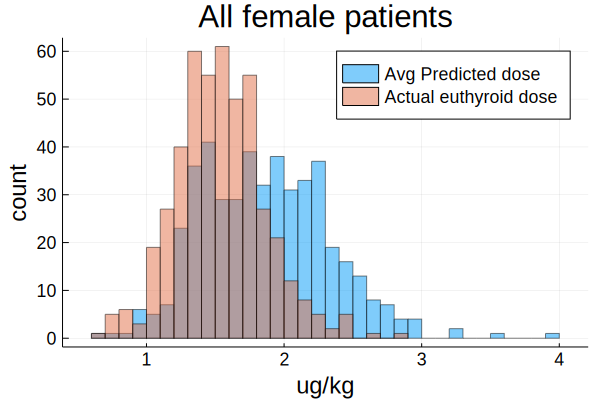

In [32]:
# make female plot
dosage_predicted = readdlm("schneider_dosage_prediction_result.txt")
predicted_t4 = dosage_predicted[female_idx, 2] ./ all_schneider[female_idx, Symbol("Wt.kg")]
avgplt_female = histogram(predicted_t4, title="All female patients", bin=50, 
    xlabel="ug/kg", ylabel="count", label="Avg Predicted dose", alpha=0.5)

# actual dose
actual_t4 = all_schneider[female_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[female_idx, Symbol("Wt.kg")]
histogram!(avgplt_female, actual_t4, label="Actual euthyroid dose", bin=30, alpha=0.5)

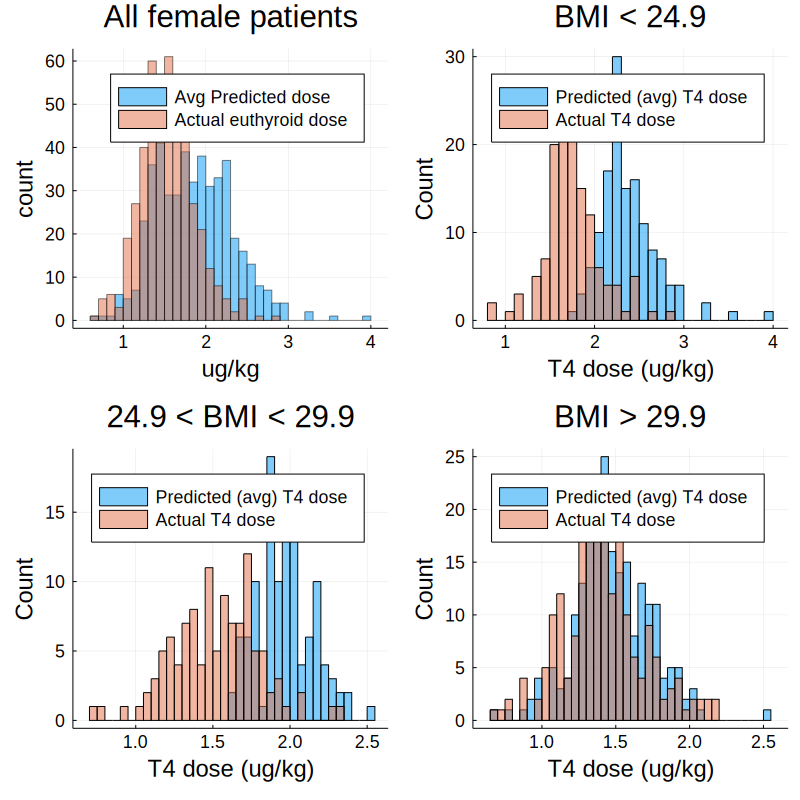

In [34]:
# import predicted dosages: max-dose/avg-dose/min-dose
dosage_predicted = readdlm("schneider_dosage_prediction_result.txt")
normal_idx = findall(bmi -> bmi < 24.9, all_schneider[!, :BMI])
overwt_idx = findall(bmi -> 24.9 <= bmi < 29.9, all_schneider[!, :BMI])
obese_idx  = findall(bmi -> 29.9 <= bmi, all_schneider[!, :BMI]);
normal_female_idx = findall(isone, all_schneider[normal_idx, :Sex])
overwt_female_idx = findall(isone, all_schneider[overwt_idx, :Sex])
obese_female_idx  = findall(isone, all_schneider[obese_idx , :Sex])

# normal female patients (avg dose)
normal_weight = all_schneider[normal_idx, Symbol("Wt.kg")]
normal_weight = normal_weight[normal_female_idx]
normal_predicted_dose = dosage_predicted[normal_idx, 2][normal_female_idx] ./ normal_weight
normal_euthy_dose = all_schneider[normal_idx, Symbol("LT4.euthyroid.dose")][normal_female_idx] ./ normal_weight
normal_plt = histogram(normal_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", title="BMI < 24.9", bin=30, 
    fillalpha=0.5)
histogram!(normal_plt, normal_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.5)

# overweight female patients (avg dose)
overweight_weight = all_schneider[overwt_idx, Symbol("Wt.kg")]
overweight_weight = overweight_weight[overwt_female_idx]
overweight_predicted_dose = dosage_predicted[overwt_idx, 2][overwt_female_idx] ./ overweight_weight
overweight_euthy_dose = all_schneider[overwt_idx, Symbol("LT4.euthyroid.dose")][overwt_female_idx] ./ overweight_weight
overweight_plt = histogram(overweight_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", title="24.9 < BMI < 29.9", bin=30, 
    fillalpha=0.5)
histogram!(overweight_plt, overweight_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.5)

# obese female patients (avg dose)
obese_weight = all_schneider[obese_idx, Symbol("Wt.kg")]
obese_weight = obese_weight[obese_female_idx]
obese_predicted_dose = dosage_predicted[obese_idx, 2][obese_female_idx] ./ obese_weight
obese_euthy_dose = all_schneider[obese_idx, Symbol("LT4.euthyroid.dose")][obese_female_idx] ./ obese_weight
obese_plt = histogram(obese_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", title="BMI > 29.9", bin=40, 
    fillalpha=0.5)
histogram!(obese_plt, obese_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.5)

female_combined = plot(avgplt_female, normal_plt, overweight_plt, obese_plt, layout = (2, 2), size=(800, 800))

In [35]:
savefig(female_combined, "female_predicted_dose_per_kg.svg")

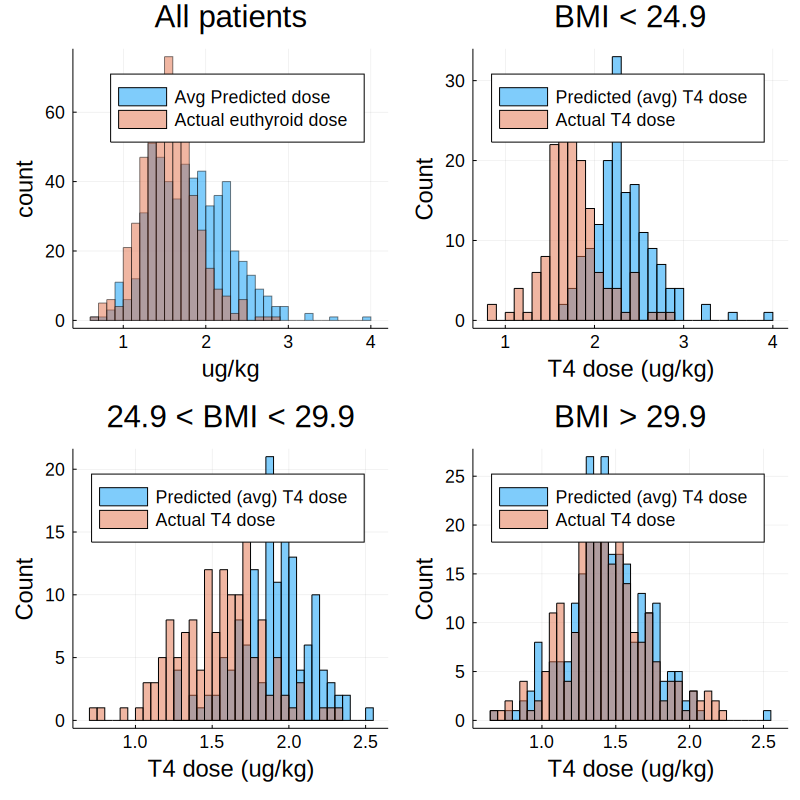

In [36]:
# all patients
# import predicted dosages: max-dose/avg-dose/min-dose
dosage_predicted = readdlm("schneider_dosage_prediction_result.txt")
normal_idx = findall(bmi -> bmi < 24.9, all_schneider[!, :BMI])
overwt_idx = findall(bmi -> 24.9 <= bmi < 29.9, all_schneider[!, :BMI])
obese_idx  = findall(bmi -> 29.9 <= bmi, all_schneider[!, :BMI]);

# normal patients (avg dose)
normal_weight = all_schneider[normal_idx, Symbol("Wt.kg")]
normal_predicted_dose = dosage_predicted[normal_idx, 2] ./ normal_weight
normal_euthy_dose = all_schneider[normal_idx, Symbol("LT4.euthyroid.dose")] ./ normal_weight
normal_plt = histogram(normal_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", title="BMI < 24.9", bin=30, 
    fillalpha=0.5)
histogram!(normal_plt, normal_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.5)

# overweight patients (avg dose)
overweight_weight = all_schneider[overwt_idx, Symbol("Wt.kg")]
overweight_predicted_dose = dosage_predicted[overwt_idx, 2] ./ overweight_weight
overweight_euthy_dose = all_schneider[overwt_idx, Symbol("LT4.euthyroid.dose")] ./ overweight_weight
overweight_plt = histogram(overweight_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", title="24.9 < BMI < 29.9", bin=30, 
    fillalpha=0.5)
histogram!(overweight_plt, overweight_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.5)


# obese patients (avg dose)
obese_weight = all_schneider[obese_idx, Symbol("Wt.kg")]
obese_predicted_dose = dosage_predicted[obese_idx, 2] ./ obese_weight
obese_euthy_dose = all_schneider[obese_idx, Symbol("LT4.euthyroid.dose")] ./ obese_weight
obese_plt = histogram(obese_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", title="BMI > 29.9", bin=40, 
    fillalpha=0.5)
histogram!(obese_plt, obese_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.5)

combined = plot(avgplt_all, normal_plt, overweight_plt, obese_plt, layout = (2, 2), size=(800, 800))

In [37]:
savefig(combined, "predicted_dose_per_kg.svg")

# Record predicted dose and error into schneider dataframe

In [39]:
function one_simulation(
    current_iter,
    fitting_index, 
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    tspan::Float64,
    initial_tsh::Float64,
    euthyroid_dose::Float64,
    initial_dose::Float64
    )
    
    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex)
    ic[7] = initial_tsh
    tot_loss = zero(Int)
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= current_iter
    
    # calculate error for euthyroid dose
    p[55] = euthyroid_dose / 777.0
    prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
    sol   = solve(prob, save_idxs=7)
    
    #increment error
    tot_loss += compute_euthyroid_dose_l2_error(sol, p[48])
    
    # when initial dose != euthyroid dose, calculate error
    if initial_dose != euthyroid_dose
        p[55] = initial_dose / 777.0
        prob = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol = solve(prob, save_idxs=7)
        tot_loss += compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose, p[48])
    end

    return tot_loss
end

function record_error(
    train_data, 
    train_minimizer, 
    fitting_index, 
    euthy_dose,
    init_dose, 
    )
    # parse data
    height = train_data[!, Symbol("Ht.m")]
    weight = train_data[!, Symbol("Wt.kg")]
    sex    = train_data[!, Symbol("Sex")]
    tspan  = 24train_data[!, Symbol("Days.to.euthyroid")]
    init_tsh = train_data[!, Symbol("TSH.preop")]
    
    # model setup
    cbk   = PeriodicCallback(add_dose!, 24.0)# function to add dose
    dial  = [0.0; 0.88; 0.0; 0.88]
    scale_Vp = true

    # loop over each patient
    patient_error = zeros(size(train_data, 1))
    for i in 1:size(train_data, 1)
        w     = weight[i]
        h     = height[i]
        s     = Bool(sex[i])
        t     = Float64(tspan[i])
        ic, p = initialize(dial, scale_Vp, h, w, s)
        p[fitting_index] = train_minimizer
        ic[7] = init_tsh[i]
        
        # record error
        patient_error[i] = one_simulation(train_minimizer, fitting_index, h, w, s, t, 
            init_tsh[i], euthy_dose[i], init_dose[i])
    end
    
    return patient_error
end

record_error (generic function with 1 method)

In [41]:
# read predicted dosage
result = readdlm("schneider_dosage_prediction_result.txt")

# calculate each patient's (unscaled) error contribution to schneider 
# patient_error = record_error(all_schneider, train_minimizer, fitting_index, 
#     all_schneider[!, Symbol("LT4.euthyroid.dose")], 
#     all_schneider[!, Symbol("LT4.initial.dose")])

# combine results
combined = deepcopy(all_schneider)
insertcols!(combined, size(combined, 2) + 1, (:max_predicted_dose => result[:, 1]))
insertcols!(combined, size(combined, 2) + 1, (:avg_predicted_dose => result[:, 2]))
insertcols!(combined, size(combined, 2) + 1, (:min_predicted_dose => result[:, 3]))
# insertcols!(combined, size(combined, 2) + 1, (:error_contribution => patient_error))

,Surgeon,Race,Sex,Age,Wt.lb,Wt.kg,Ht.in,Ht.m,BMI,LT4.initial.dose
,String,Int64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64
1,3,1,0,60.1,254,115.2,71.5,1.8161,34.9279,175.0
2,1,1,1,65.0,170,77.1,68.0,1.7272,25.8446,125.0
3,2,1,1,61.4,113,51.3,62.0,1.5748,20.6855,100.0
4,1,1,1,66.4,103,46.7,61.0,1.5494,19.4531,88.0
5,2,1,0,64.4,224,101.6,68.0,1.7272,34.0572,175.0
6,1,1,1,63.2,227,103.0,62.0,1.5748,41.5323,150.0
7,1,1,1,59.0,167,75.7,64.0,1.6256,28.6463,112.0
8,1,1,1,50.3,203,92.1,65.0,1.651,33.7882,137.0
9,2,1,0,69.1,204,92.5,71.0,1.8034,28.4418,175.0


In [42]:
using CSV
CSV.write("schneider_dose_error.csv", combined)

"schneider_dose_error.csv"